In [17]:

import xml.etree.ElementTree as ET
import networkx as nx
from rich import print
import json
import os
from tqdm import tqdm

def parse_xml_to_graph(xml_data):
    # Parse the XML data
    root = ET.fromstring(xml_data)
    
    # Create a new graph
    G = nx.Graph()

    # Iterate over each vertex in the XML
    for i, vertex in enumerate(root.find('graph').findall('vertex')):
        source = str(i)  # Using the index as the vertex ID, converted to string
        # Iterate over each edge for this vertex
        for edge in vertex.findall('edge'):
            target = edge.text
            cost = float(edge.get('cost'))
            # Add an edge to the graph
            G.add_edge(source, target, weight=cost)

    return G

file = 'brazil58.xml'
# file = 'burma14.xml'

xml_data = open(f'datasets/{file}').read()

# Parse the XML and create the graph
graph = parse_xml_to_graph(xml_data)


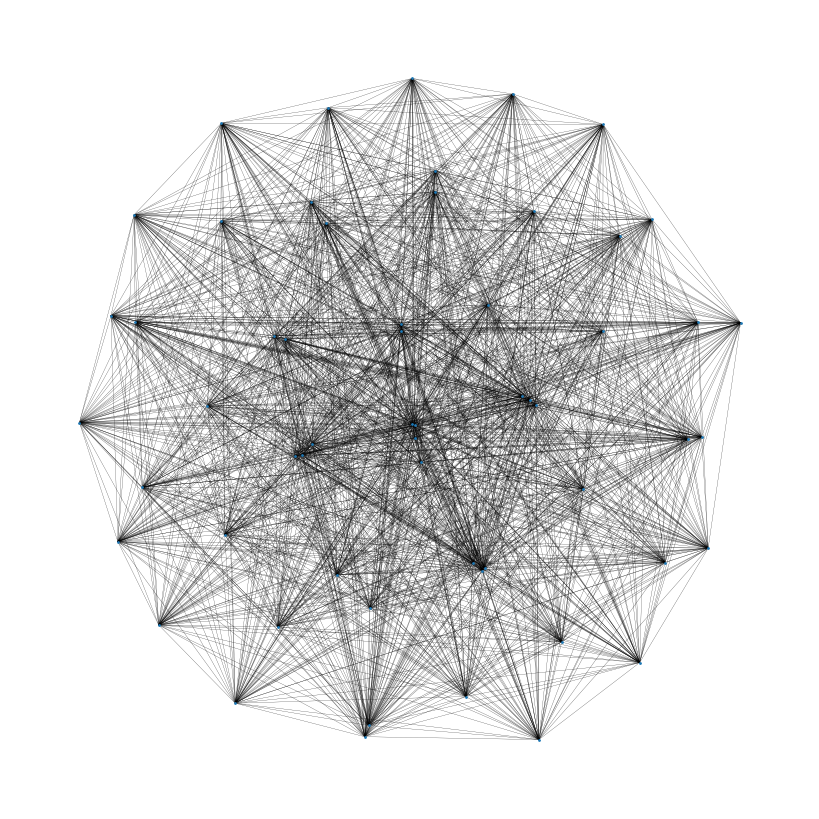

In [18]:
# output the graph using matplotlib
import matplotlib.pyplot as plt
width = 8
plt.figure(figsize=(width, width))
layout = nx.spring_layout(graph, seed=3, k = .5, iterations=2000)
nx.draw(graph, with_labels=False, node_size=1, width=0.15, pos=layout)

In [19]:
import numpy as np

def convert_graph_to_matrix(graph):
    # Converts the NetworkX graph into a NumPy matrix.

    # Create a NumPy matrix of zeros
    n = len(graph.nodes)
    matrix = np.zeros((n, n))

    # Populate the matrix with distances
    for i, node_i in enumerate(graph.nodes):
        for j, node_j in enumerate(graph.nodes):
            if i != j:
                try:
                    # get the 'weight' attribute for the edge
                    matrix[i][j] = graph[node_i][node_j]['weight']
                except KeyError:
                    # If the edge does not exist or has no weight, set a large number
                    matrix[i][j] = float('inf')

    return matrix

# Convert the graph into a NumPy matrix
matrix = convert_graph_to_matrix(graph)
print(matrix)

[[   0. 2635. 2713. ... 3870. 1417.  739.]
 [2635.    0.  314. ... 2072. 1196. 1517.]
 [2713.  314.    0. ... 1882. 2699. 1557.]
 ...
 [3870. 2072. 1882. ...    0. 2328. 2986.]
 [1417. 1196. 2699. ... 2328.    0.  962.]
 [ 739. 1517. 1557. ... 2986.  962.    0.]]

In [20]:
import numpy as np
import random


class AntColonyOptimizer:
    def __init__(self, distance_matrix, num_ants, evaporation_rate, alpha, beta, Q, max_fitness_evaluations, local_heuristic):
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.max_fitness_evaluations = max_fitness_evaluations
        self.num_cities = distance_matrix.shape[0]

        self.eta = local_heuristic / (distance_matrix + np.finfo(float).eps)  # Eta is visibility, which is 1/distance
        self.eta[np.eye(self.num_cities, dtype=bool)] = 0  # Set diagonal to zero to avoid self-loop

        self.best_solution = None
        self.best_cost = float('inf')
        self.elitist_weight = 1  # Adjust as needed, this is the extra weight for the best ant

        # Initialize pheromone levels
        self.pheromone_matrix = np.random.uniform(low=0.1, high=1.0, size=(self.num_cities, self.num_cities))
        self.pheromone_delta = np.zeros_like(self.distance_matrix)

        # Tracking attributes
        self.pheromone_evolution = []  # To track pheromone matrix changes over time
        self.best_cost_evolution = []  # To track the best cost found over time
        self.solution_diversity = []
        self.pheromone_intensity_distribution = []
        self.iteration_improvement = []
        self.ant_consistency = {ant: [] for ant in range(self.num_ants)}
        self.path_stability = []
        self.path_convergence = []


    def run(self):
        best_cost = float('inf')
        best_solution = None
        fitness_evaluations = 0

        start_city = np.random.randint(self.num_cities)  # Start at a random city

        while fitness_evaluations < self.max_fitness_evaluations:
            solutions = []

            for _ in range(self.num_ants):
                solution, cost = self.generate_solution(start_city)
                solutions.append((solution, cost))

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

                fitness_evaluations += 1
                if fitness_evaluations >= self.max_fitness_evaluations:
                    break

            self.update_pheromones(solutions)
            self.evaporate_pheromones()
            self.best_cost_evolution.append(best_cost)  # Record best cost evolution
            if len(self.best_cost_evolution) > 1:
                improvement = self.best_cost_evolution[-2] - self.best_cost_evolution[-1]
                self.iteration_improvement.append(improvement)

            # self.solution_diversity.append(self.calculate_solution_diversity(solutions))
            self.pheromone_intensity_distribution.append(np.std(self.pheromone_matrix))
            self.path_stability.append(self.calculate_path_stability())
            self.path_convergence.append(self.calculate_path_convergence())


            for solution, cost in solutions:
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = solution

            start_city = (start_city + 1) % self.num_cities  # Change start city for next iteration

        return best_solution, best_cost

    def generate_solution(self, start_city):
        path = [start_city]  # Start at the given city
        visited = set(path)

        while len(path) < self.num_cities:
            next_city = self.select_next_city(path[-1], visited)
            path.append(next_city)
            visited.add(next_city)

        cost = self.calculate_path_cost(path)
        return path, cost


    # def select_next_city(self, current_city, visited):
    #     unvisited_cities = [city for city in range(self.num_cities) if city not in visited]
    #     probabilities = []

    #     for city in unvisited_cities:
    #         tau = self.pheromone_matrix[current_city][city] ** self.alpha
    #         eta = self.eta[current_city][city] ** self.beta  # Use precomputed eta value
    #         probabilities.append(tau * eta)

    #     total = sum(probabilities)
    #     if total <= 0:
    #         # Fallback: Choose randomly from remaining unvisited cities
    #         if unvisited_cities:
    #             return random.choice(unvisited_cities)
    #         else:
    #             raise Exception("No unvisited cities left, but path is incomplete. Check logic.")

    #     probabilities = [p / total for p in probabilities]  # Normalize probabilities
    #     next_city = random.choices(unvisited_cities, weights=probabilities, k=1)[0]
    #     return next_city

    def select_next_city(self, current_city, visited):
        # Assuming visited is a set for O(1) lookups
        unvisited_cities = [city for city in range(self.num_cities) if city not in visited]

        if not unvisited_cities:
            raise Exception("No unvisited cities left, but path is incomplete. Check logic.")

        cumulative_probabilities = []
        cumulative_sum = 0

        for city in unvisited_cities:
            tau = self.pheromone_matrix[current_city][city] ** self.alpha
            eta = self.eta[current_city][city] ** self.beta
            cumulative_sum += tau * eta
            cumulative_probabilities.append(cumulative_sum)

        if cumulative_sum <= 0:
            # Fallback: Choose randomly from remaining unvisited cities
            return random.choice(unvisited_cities)

        # Select next city based on cumulative probabilities
        random_threshold = random.uniform(0, cumulative_sum)
        for i, city_prob in enumerate(cumulative_probabilities):
            if random_threshold <= city_prob:
                return unvisited_cities[i]


    def calculate_path_cost(self, path):
        path_array = np.array(path)
        return np.sum(self.distance_matrix[path_array[:-1], path_array[1:]]) + self.distance_matrix[path[-1], path[0]]


    def update_pheromones(self, solutions):
        # Reset the pheromone delta matrix
        self.pheromone_delta.fill(0)

        # Update pheromone for all ants
        for solution, cost in solutions:
            indices = np.array(solution)
            self.pheromone_delta[indices[:-1], indices[1:]] += self.Q / cost

        # Additional pheromone for the best solution so far
        if self.best_solution is not None:
            best_indices = np.array(self.best_solution)
            self.pheromone_delta[best_indices[:-1], best_indices[1:]] += self.elitist_weight * self.Q / self.best_cost

        # Update the pheromone matrix
        self.pheromone_matrix += self.pheromone_delta
        self.pheromone_evolution.append(self.pheromone_matrix.copy())

    def evaporate_pheromones(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)

    def calculate_path_convergence(self):
        # Calculate the convergence of paths based on the pheromone matrix
        # High pheromone levels on the same paths indicate convergence
        max_pheromones = np.max(self.pheromone_matrix, axis=1)  # Max pheromone for each city
        convergence_score = np.mean(max_pheromones) / np.mean(self.pheromone_matrix)
        return convergence_score

    def calculate_path_stability(self):
        # Path stability can be measured as the inverse of the average change in pheromone levels
        if len(self.pheromone_evolution) < 2:
            return 0  # No change if we don't have at least two pheromone matrices to compare
        pheromone_changes = np.abs(self.pheromone_evolution[-1] - self.pheromone_evolution[-2])
        return 1 / np.mean(pheromone_changes)


    def get_metrics(self):
        return self.best_cost_evolution, self.pheromone_evolution, self.path_convergence, self.pheromone_intensity_distribution, self.iteration_improvement, self.path_stability


In [21]:
# def profile_run(aco):
#     profiler = cProfile.Profile()
#     profiler.enable()  # Start profiling
#     best_solution, best_cost = aco.run()
#     profiler.disable()  # Stop profiling
    
#     s = io.StringIO()
#     sortby = 'cumulative'  # 'cumulative' for cumulative time, 'time' for total time, or 'calls' for call count
#     ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
#     ps.print_stats()
#     print(s.getvalue())  # Print out the statistics

# # Create your ACO instance
# aco = AntColonyOptimizer(matrix, num_ants=10, evaporation_rate=evaporation_rate, alpha=alpha, beta=beta, Q=Q, max_fitness_evaluations=10000, local_heuristic=local_heuristic)

# # Profile your ACO run
# profile_run(aco)


In [22]:
# best_cost = float('inf')



# while best_cost > 30000:
#     aco = AntColonyOptimizer(matrix, num_ants=10, evaporation_rate=0.1, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000, local_heuristic=1)
#     best_solution, best_cost = aco.run()
#     # print("Best Solution:", best_solution)
#     print("Best Cost:", best_cost)


# 25769.0
# 13.8s
# 26100.0
# # run it with different number of ants
# ant_nums = [10, 20, 50, 100, 200, 500, 1000]

# results = {}

# for ant_num in tqdm(ant_nums, colour='green'):
#     aco = AntColonyOptimizer(matrix, num_ants=ant_num, evaporation_rate=0.3, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000)
#     best_solution, best_cost = aco.run()
#     # print(f"Best Cost for {ant_num} ants:", best_cost)
#     results[ant_num] = best_cost

# 13.8s - 26599.0
# with changes
# 13.3s - 28106





# 3.6 - burma14.xml with heuristic
# 1.1 - burma14.xml without heuristic


# 14.8 - brazil58.xml without heuristic 25799.0
# 16.9 - brazil58.xml with heuristic

In [23]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
from tqdm import tqdm
from yaspin import yaspin

def focused_grid_search_aco(distance_matrix, base_params, range_delta, step_sizes, n_runs, max_values):
    num_ants_base, evap_rate_base, alpha_base, beta_base, Q_base, local_heuristic_base = base_params
    alpha_step, beta_step, Q_step, local_heuristic_step = step_sizes
    max_num_ants, max_alpha, max_beta, max_Q, max_local_heuristic = max_values

    # Define ranges with dynamic step sizes
    num_ants_range = range(max(10, num_ants_base - range_delta), min(num_ants_base + range_delta + 1, max_num_ants))
    evap_rate_range = np.clip([evap_rate_base - 0.05, evap_rate_base + 0.05], 0.01, 1).tolist()
    alpha_range = range(max(1, alpha_base - alpha_step), min(alpha_base + alpha_step + 1, max_alpha))
    beta_range = range(max(1, beta_base - beta_step), min(beta_base + beta_step + 1, max_beta))
    Q_range = range(max(10, Q_base - Q_step), min(Q_base + Q_step + 1, max_Q), max(1, Q_step))
    local_heuristic_range = range(max(1, local_heuristic_base - local_heuristic_step), min(local_heuristic_base + local_heuristic_step + 1, max_local_heuristic), max(1, local_heuristic_step))

    return grid_search_aco(distance_matrix, num_ants_range, evap_rate_range, alpha_range, beta_range, Q_range, local_heuristic_range, n_runs)

def run_aco_with_params(distance_matrix, num_ants, evaporation_rate, alpha, beta, Q, local_heuristic, n_runs):
    best_cost = float('inf')
    best_solution = None

    for _ in range(n_runs):
        aco = AntColonyOptimizer(distance_matrix, num_ants, evaporation_rate, alpha, beta, Q=Q, max_fitness_evaluations=10000, local_heuristic=local_heuristic)
        solution, cost = aco.run()
        if cost < best_cost:
            best_cost = cost
            best_solution = solution

    return best_cost, best_solution

def grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options, Q_options, local_heuristic_options, n_runs):
    with ProcessPoolExecutor() as executor:
        futures = {}
        total_combinations = len(num_ants_options) * len(evaporation_rate_options) * len(alpha_options) * len(beta_options) * len(Q_options) * len(local_heuristic_options)
        for params in product(num_ants_options, evaporation_rate_options, alpha_options, beta_options, Q_options, local_heuristic_options):
            num_ants, evaporation_rate, alpha, beta, Q, local_heuristic = params
            future = executor.submit(run_aco_with_params, distance_matrix, num_ants, evaporation_rate, alpha, beta, Q, local_heuristic, n_runs)
            futures[future] = params

        results = []
        for future in tqdm(as_completed(futures), total=total_combinations, desc="Evaluating ACO Parameters"):
            result = future.result()
            param_set = futures[future]
            results.append((result, param_set))

    return results

distance_matrix = convert_graph_to_matrix(graph)
num_ants_options = [10, 20, 50, 100]
evaporation_rate_options = [0.1, 0.5, 0.9]
alpha_options = [1, 2, 3]
beta_options = [1, 2, 3]
Q_options = [10, 50, 100]
local_heuristic_options = [1, 50, 100]
n_runs = 3  # Number of times to run ACO for each parameter set

# Check if there are already results for this dataset
file_name = f'results/results_{file.split(".")[0]}.json'
if os.path.exists(file_name):
    print("Loading best parameter set from file...")
    with open(file_name) as f:
        results = json.load(f)

    num_ants, evaporation_rate, alpha, beta, Q, local_heuristic = results['best_param_set']

    print('Starting ACO with best parameter set...')
    aco = AntColonyOptimizer(matrix, num_ants=num_ants, evaporation_rate=evaporation_rate, alpha=alpha, beta=beta, Q=Q, max_fitness_evaluations=10000, local_heuristic=local_heuristic)

    with yaspin() as spinner:
        best_solution, best_cost = aco.run()
        spinner.ok("✓")

else:
    results = grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options, Q_options, local_heuristic_options, n_runs)

    # base_params = [23, 0.15, 1, 2, 50, 1]
    # range_delta = 5  # Initial range delta
    # step_sizes = [1, 1, 10, 10]  # Initial step sizes for alpha, beta, Q, and local_heuristic
    # max_values = [100, 5, 5, 200, 150]  # max_num_ants, max_alpha, max_beta, max_Q, max_local_heuristic

    # for i in range(10):
    #     results = focused_grid_search_aco(distance_matrix, base_params, range_delta, step_sizes, n_runs, max_values)
    #     (best_cost, best_solution), best_param_set = min(results, key=lambda x: x[0][0])
    #     base_params = list(best_param_set)

    #     # Update range_delta and step_sizes for next iteration
    #     range_delta = max(1, range_delta - 1)
    #     step_sizes = [max(1, step - 1) for step in step_sizes]  # Reduce step sizes

    #     print(f"Iteration {i+1}: Best Cost: {best_cost}, Best Params: {base_params}")

    (best_cost, best_solution), best_param_set = min(results, key=lambda x: x[0][0])
    print("Best Result:", best_cost)
    print("Best Parameter Set:", best_param_set)

# 12 seconds

Loading best parameter set from file...

Starting ACO with best parameter set...

⠦  

✓  


In [24]:
# res = []

# # best_param_set = best_param_set

# for i in range(1):
#     aco = AntColonyOptimizer(matrix, num_ants=best_param_set[0], evaporation_rate=best_param_set[1], alpha=best_param_set[2], beta=best_param_set[3], Q=best_param_set[4], max_fitness_evaluations=10000, local_heuristic=best_param_set[5])
#     best_solution, best_cost = aco.run()
#     print('best_cost: ', best_cost)
#     res.append(best_cost)


# print('mean: ', np.mean(res))

In [25]:
# # # "best_param_set": [
# # #         20,
# # #         0.1,
# # #         1,
# # #         2,
# # #         100,
# # #         1
# # #     ]

# import random

# def run_aco():
#     factor = 1# + random.uniform(-0.1, 0.1)  # Generate a random factor between 90% (1 - 0.1) and 110% (1 + 0.1)
    
#     ants, evap, alpha, beta, Q, max_evals, local_heuristic = best_param_set[0], best_param_set[1], best_param_set[2], best_param_set[3], best_param_set[4], 10000, best_param_set[5]
    
#     aco = AntColonyOptimizer(matrix, num_ants=ants, evaporation_rate=evap, alpha=alpha, beta=beta, Q=Q, max_fitness_evaluations=max_evals, local_heuristic=local_heuristic)
#     best_solution, best_cost = aco.run()
#     return best_cost, best_solution, [ants, evap, alpha, beta, Q, max_evals, local_heuristic]

# def multithreaded_aco_runs(num_runs):
#     res = []
#     with ProcessPoolExecutor() as executor:
#         futures = [executor.submit(run_aco) for _ in range(num_runs)]
#         for future in tqdm(as_completed(futures), total=num_runs, colour='green'):
#             res.append(future.result())
#     return min(res, key=lambda x: x[0])

# best_cost = float('inf')

# best_dict = {}

# n = 1

# while best_cost > 25411:
#     best_cost, best_solution, params = multithreaded_aco_runs(100)
#     print(f'best cost after {n * 100} runs: {best_cost}')
#     best_dict[best_cost] = (best_solution, params)
#     n+=1
    
#     # if len(best_dict) > 10:
#     #     break

In [26]:
# Save the best parameters as a json file if the best result is lower than the previous best result
file_name = f'results/results_{file.split(".")[0]}.json'

# Load the previous best result
if os.path.exists(file_name):
    with open(file_name) as f:
        best_result = json.load(f)
else:
    best_result = {'best_cost': float('inf')}
    
# If the new result is better than the previous best result, save the new result
if best_cost < best_result['best_cost']:
    best_result['best_cost'] = best_cost
    best_result['best_solution'] = best_solution
    best_result['best_param_set'] = best_param_set

    with open(file_name, 'w') as f:
        # save the best result and the parameters used to generate it
        json.dump(best_result, f, indent=4)
else:
    # If its not then get the best result from the file
    best_cost = best_result['best_cost']
    best_solution = best_result['best_solution']    


In [27]:
# # Run the ACO algorithm n times and then tabulate the results including the average and standard deviation, and the best result
# n = 1000
# results = []

# # Get the best params from the file
# with open(file_name) as f:
#     best_result = json.load(f)
#     best_param_set = best_result['best_param_set']

# nums_ant, evaporation_rate, alpha, beta, Q, local_heuristic = best_param_set

# def run_aco():
#     aco = AntColonyOptimizer(matrix, num_ants=nums_ant, evaporation_rate=evaporation_rate, alpha=alpha, beta=beta, Q=Q, max_fitness_evaluations=10000, local_heuristic=local_heuristic)
#     best_solution, best_cost = aco.run()
    
#     return best_cost, best_solution

# def multithreaded_aco_runs(num_runs):
#     res = []
#     with ProcessPoolExecutor() as executor:
#         futures = [executor.submit(run_aco) for _ in range(num_runs)]
#         for future in tqdm(as_completed(futures), total=num_runs, colour='green'):
#             res.append(future.result())
#     return res

# results = multithreaded_aco_runs(n)

# costs, solutions = zip(*results)

# # Create a table of the results
# import pandas as pd
# from collections import Counter

# # Assuming the rest of your code remains the same

# def get_city_visits(solution):
#     city_counts = Counter(solution)
#     return np.mean(list(city_counts.values())), np.std(list(city_counts.values()))

# def get_edge_visits(solution):
#     edge_counts = Counter(zip(solution, solution[1:] + solution[:1]))
#     return np.mean(list(edge_counts.values())), np.std(list(edge_counts.values()))

# # Prepare data for DataFrame
# data = []

# for cost, solution in results:
#     avg_city_visits, std_dev_city_visits = get_city_visits(solution)
#     avg_edge_visits, std_dev_edge_visits = get_edge_visits(solution)
#     data.append({
#         'Cost': cost, 
#         'Solution': solution
#     })

# # Create DataFrame
# df = pd.DataFrame(data)

# # Calculating overall statistics
# df['Best Result'] = df['Cost'].min()
# df['Avg Result'] = df['Cost'].mean()
# df['Std Dev Result'] = df['Cost'].std()
# df['Worst Result'] = df['Cost'].max()
# df['Unique Results'] = df['Cost'].nunique()
# df['Best Result Count'] = (df['Cost'] == df['Best Result']).sum()
# # Add a best result count column
# df['Best Result Count'] = (df['Cost'] == df['Best Result']).sum()
# # Add a best result % column
# df['Best Result %'] = df['Best Result Count'] / n * 100

# # Sort the DataFrame by cost
# df.sort_values(by=['Cost'], inplace=True)

# # Remove duplicate solutions
# df.drop_duplicates(subset=['Solution'], inplace=True)

# df


Running ACO:   0%|          | 0/4 [00:00<?, ?it/s]

Running ACO: 100%|██████████| 4/4 [00:54<00:00, 13.63s/it]


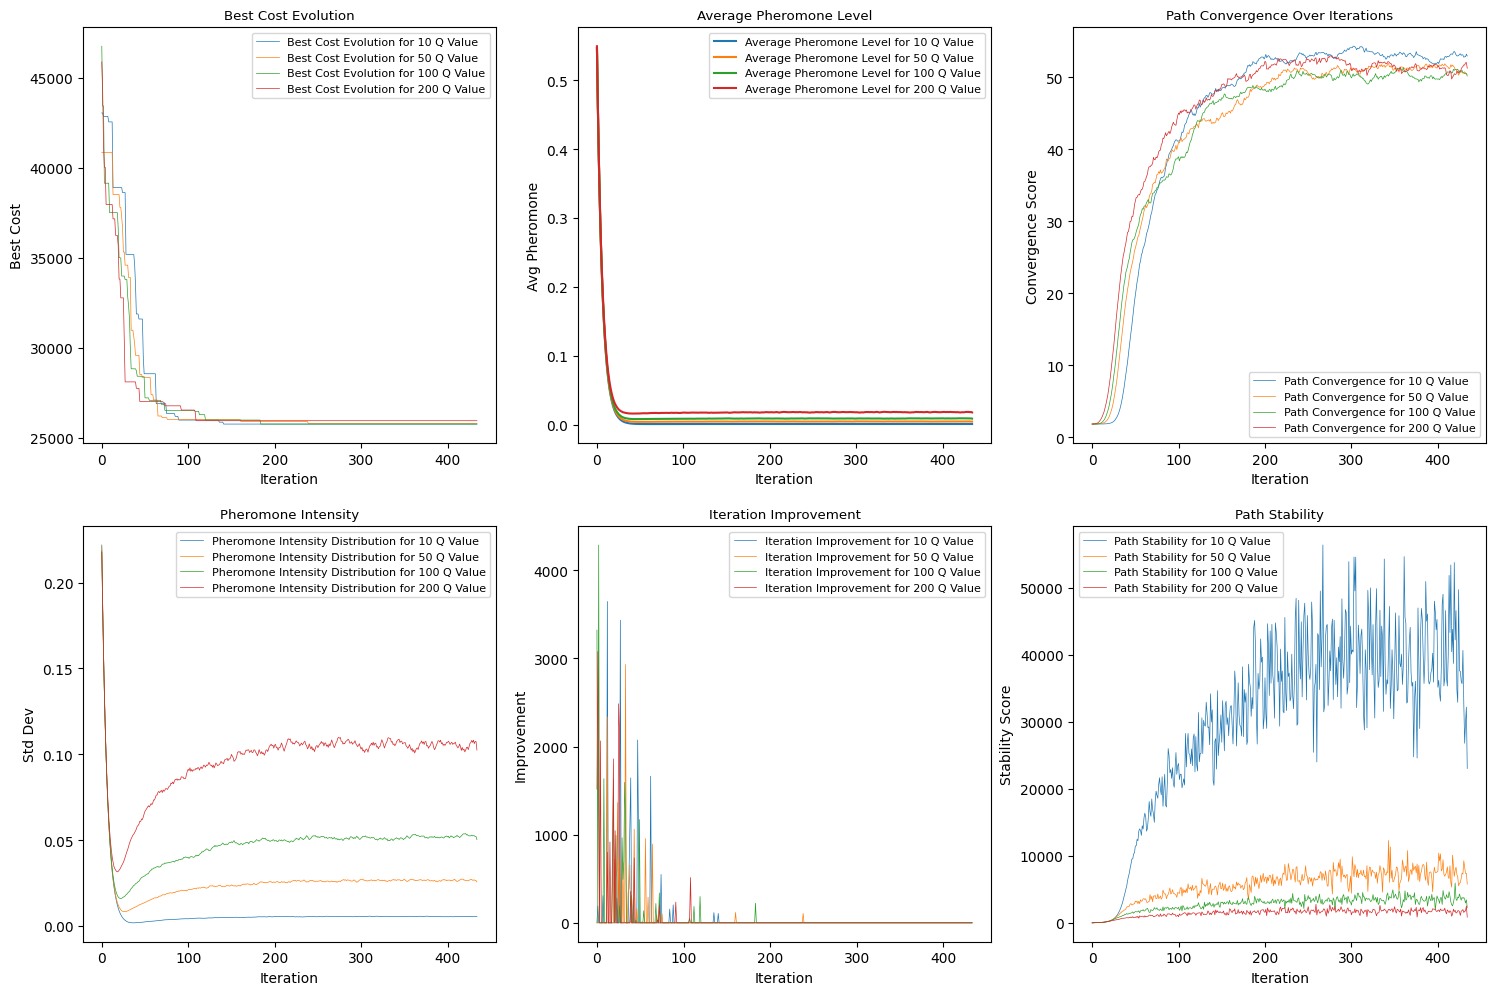

In [28]:
params = [
    [23, 0.15, 1, 2, 10, 1],  # Low Q value
    [23, 0.15, 1, 2, 50, 1],  # Moderate Q value
    [23, 0.15, 1, 2, 100, 1], # High Q value
    [23, 0.15, 1, 2, 200, 1]  # Very high Q value
]

metrics = []

for param in tqdm(params, colour='green', desc='Running ACO'):
    num_ants, evaporation_rate, alpha, beta, Q, local_heuristic = param
    aco = AntColonyOptimizer(matrix, num_ants=num_ants, evaporation_rate=evaporation_rate, alpha=alpha, beta=beta, Q=Q, max_fitness_evaluations=10000, local_heuristic=local_heuristic)
    _, _ = aco.run()
    # print('best_cost: ', best_cost)
    metrics.append(aco.get_metrics())

# Assuming you've already run the ACO algorithm and obtained the metrics


# Create a figure with subplots in a 2x3 grid layout for a more compact display
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Adjust the font size for a more compact display
plt.rcParams.update({'font.size': 8})

# Plotting Best Cost Evolution
for i, metric in enumerate(metrics):
    axes[0].plot(metric[0], label=f'Best Cost Evolution for {params[i][4]} Q Value', linewidth=0.5)
# axes[0].plot(metrics[0], label='Best Cost Evolution', color='blue')
axes[0].set_title('Best Cost Evolution')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Best Cost')
axes[0].legend()

# Plotting Pheromone Evolution
# avg_pheromone_levels = [np.mean(matrix) for matrix in metrics[1]]
for i, metric in enumerate(metrics):
    avg_pheromone_levels = [np.mean(matrix) for matrix in metric[1]]
    axes[1].plot(avg_pheromone_levels, label=f'Average Pheromone Level for {params[i][4]} Q Value')
# axes[1].plot(avg_pheromone_levels, label='Average Pheromone Level', color='red')
axes[1].set_title('Average Pheromone Level')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Avg Pheromone')
axes[1].legend()

# Plotting Path Convergence
for i, metric in enumerate(metrics):
    axes[2].plot(metric[2], label=f'Path Convergence for {params[i][4]} Q Value', linewidth=0.5)
# axes[2].plot(metrics[2], label='Path Convergence', color='purple')
axes[2].set_title('Path Convergence Over Iterations')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Convergence Score')
axes[2].legend()

# Plotting Pheromone Intensity Distribution
for i, metric in enumerate(metrics):
    axes[3].plot(metric[3], label=f'Pheromone Intensity Distribution for {params[i][4]} Q Value', linewidth=0.5)
# axes[3].plot(metrics[3], label='Pheromone Intensity', color='green')
axes[3].set_title('Pheromone Intensity')
axes[3].set_xlabel('Iteration')
axes[3].set_ylabel('Std Dev')
axes[3].legend()

# Plotting Iteration Improvement
for i, metric in enumerate(metrics):
    axes[4].plot(metric[4], label=f'Iteration Improvement for {params[i][4]} Q Value', linewidth=0.5)
# axes[4].plot(metrics[4], label='Iteration Improvement', color='orange', linewidth=0.8)
axes[4].set_title('Iteration Improvement')
axes[4].set_xlabel('Iteration')
axes[4].set_ylabel('Improvement')
axes[4].legend()

# Plotting Path Stability
for i, metric in enumerate(metrics):
    axes[5].plot(metric[5], label=f'Path Stability for {params[i][4]} Q Value', linewidth=0.5)
# axes[5].plot(metrics[5], label='Path Stability', color='purple', linewidth=0.5)
axes[5].set_title('Path Stability')
axes[5].set_xlabel('Iteration')
axes[5].set_ylabel('Stability Score')
axes[5].legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust the spacing as needed

# Save the figure
plt.savefig('images/aco_metrics.png', dpi=800)  # Save with high dpi for better resolution in the document

# Show the plots
plt.show()

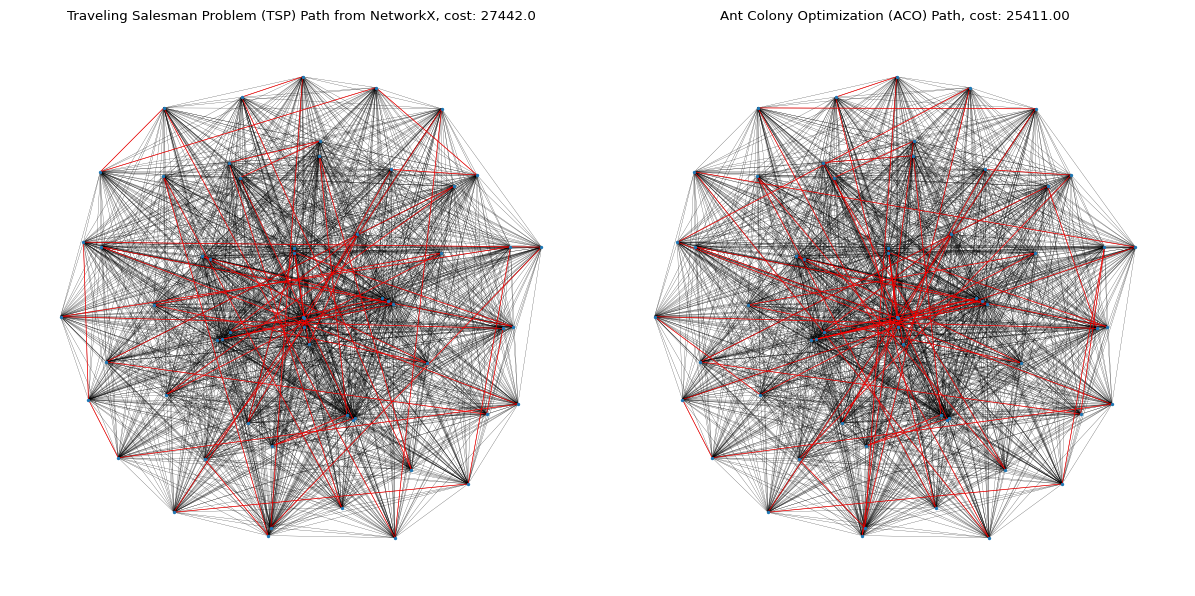

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# convert the elements of the path to strings
best_solution = [str(x) for x in best_solution]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Extract edges from the ACO path
path_edges = [(best_solution[i], best_solution[i+1]) for i in range(len(best_solution) - 1)]
path_edges.append((best_solution[-1], best_solution[0]))  # Adding edge to complete the tour
# Add the final edge to complete the tour

# Draw TSP path on the left subplot
import networkx.algorithms.approximation as nx_app
cycle = nx_app.christofides(graph, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))
# Combine the two lists into a single networkx graph
tsp_g = nx.Graph()
tsp_g.add_nodes_from(graph.nodes)
tsp_g.add_edges_from(edge_list)

ax1.set_title(f'Traveling Salesman Problem (TSP) Path from NetworkX, cost: {sum(graph[u][v]["weight"] for u, v in edge_list)}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax1)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax1)
nx.draw_networkx_edges(tsp_g, pos=layout, width=0.5, edge_color='red', ax=ax1)
ax1.axis('off')

# Draw ACO path on the right subplot
ax2.set_title(f'Ant Colony Optimization (ACO) Path, cost: {best_cost:.2f}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax2)
ax2.axis('off')



# Adjust layout and display the figure
plt.tight_layout()
# Save the figure
plt.savefig(f'images/aco_path_{file.split(".")[0]}.png', dpi=800)
plt.show()


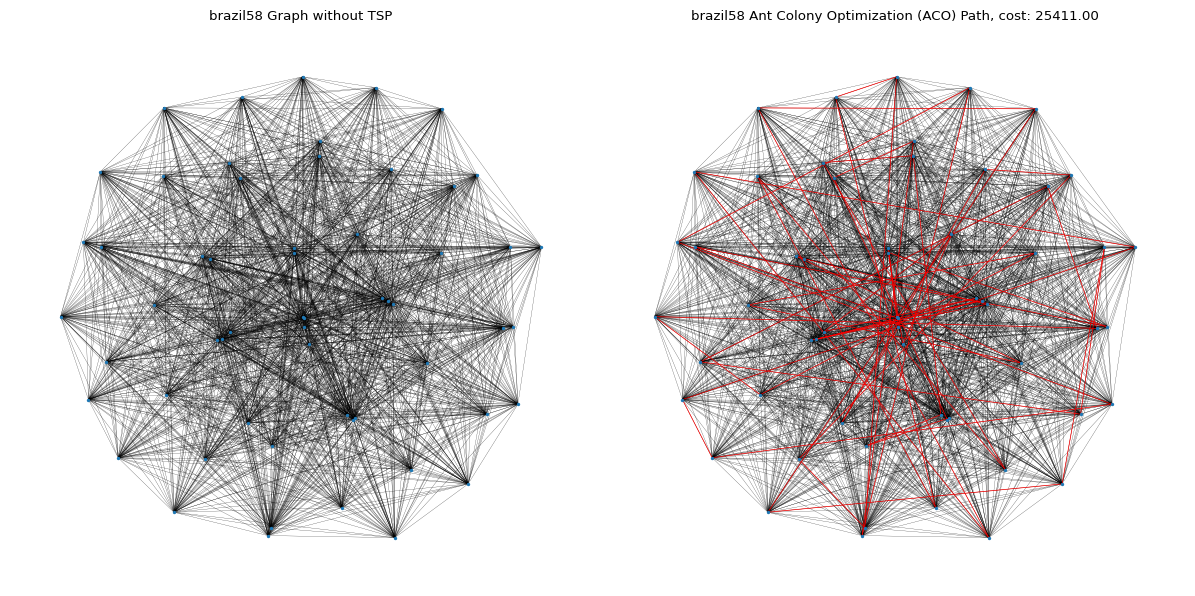

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# convert the elements of the path to strings
best_solution = [str(x) for x in best_solution]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Extract edges from the ACO path
path_edges = [(best_solution[i], best_solution[i+1]) for i in range(len(best_solution) - 1)]
path_edges.append((best_solution[-1], best_solution[0]))  # Adding edge to complete the tour
# Add the final edge to complete the tour

ax1.set_title(f'{file.split(".")[0]} Graph without TSP')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax1)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax1)
# nx.draw_networkx_edges(tsp_g, pos=layout, width=0.5, edge_color='red', ax=ax1)
ax1.axis('off')

# Draw ACO path on the right subplot
ax2.set_title(f'{file.split(".")[0]} Ant Colony Optimization (ACO) Path, cost: {best_cost:.2f}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax2)
ax2.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
# Save the figure
plt.savefig(f'images/aco_with_and_without_path_{file.split(".")[0]}.png', dpi=800)
plt.show()


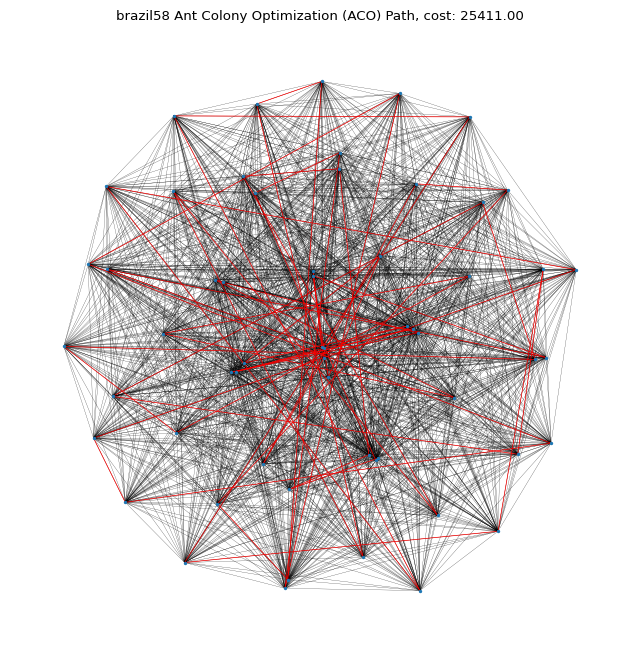

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))


ax.set_title(f'{file.split(".")[0]} Ant Colony Optimization (ACO) Path, cost: {best_cost:.2f}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax)
ax.axis('off')

plt.savefig(f'images/aco_path_single_{file.split(".")[0]}.png', dpi=800)

plt.show()
